# Bayes' Based Classifiers

In this notebook will be some additional problems regarding LDA, QDA and naive Bayes. This material corresponds to `Lectures/Supervised Learning/Classification/6. Bayes Based Classifiers`.

In [1]:
## For data handling
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

##### 1. LDA for supervised dimensionality reduction

While we introduced linear discriminant analysis (LDA) as a classification algorithm, it was originally proposed by Fisher as a supervised dimension reduction technique, <a href="https://digital.library.adelaide.edu.au/dspace/bitstream/2440/15227/1/138.pdf">https://digital.library.adelaide.edu.au/dspace/bitstream/2440/15227/1/138.pdf</a>. In particular, the initial goal was to project the features, $X$, corresponding to a binary output, $y$, onto a single dimension which best separates the possible classes. This single dimension has come to be known as <i>Fisher's discriminant</i>.

In this "problem" you will learn how this works, and then reproduce Fisher's results on the iris data set (restricted to the versicolor and setosa classes) using `sklearn`'s `LinearDiscriminantAnalysis` model object.

First load the Wisconsin cancer data set.

<i>Note that we are not making a train test split here because we are not performing classification, just dimension reduction.</i>

In [2]:
from sklearn.datasets import load_breast_cancer

In [3]:
cancer = load_breast_cancer()

X = cancer['data']
y = cancer['target']

## changing labels on y
y = -y + 1

In [4]:
from sklearn.preprocessing import StandardScaler

In [5]:
scale = StandardScaler()

X_scale = scale.fit_transform(X)

Using LDA for dimmensionality reduction we look for a vector, $w = (w_1, w_2, \dots, w_m)^T$ with $||w||_2^2=1$, to project our features onto, i.e. find $Xw = w_1 X_1 + w_2 X_2 + \dots w_m X_m$. We want to select $w$ in such a way that the spread between the two classes is maximized. In order to do that we first need to formally define what we mean by spread.

First, if we let 

$$
\mu^{(c)} = \frac{1}{N^{(c)}} \sum_{i, y^{(i)}=c} X^{(i)}, \text{ for } c=0,1
$$

where $N^{c}$ is the number of observations of class $c$, then

$$
\tilde{\mu}^{(c)} = \frac{1}{N^{(c)}} \sum_{i, y^{(i)}=c} X^{(i)} w = \mu^{(c)} w, \text{ for } c=0,1.
$$

That is, the mean for the projected data of either class is the projection of the class-specific mean vectors onto the vector $w$.

Second, if $\Sigma^{(c)}$ denotes the class $c$ specific covariance matrix of $X$, than the class $c$ specific variance of projection of $X$ onto $w$ is, $\tilde{\Sigma}^{(c)} = w^T \Sigma^{(c)} w$.


We can now define how we will measure the spread between the two classes in the projected space.

We want to choose $w$ so that:

$$
S = \frac{\left( \tilde{\mu}^{(1)} - \tilde{\mu}^{(0)} \right)^2}{\tilde{\Sigma}^{(1)} + \tilde{\Sigma}^{(0)}} = \frac{\left(\mu^{(1)} w - \mu^{(0)} w \right)^2}{w^T \left(\Sigma^{(1)} + \Sigma^{(0)} \right) w}
$$

is as large as possible. $S$ may seem like an odd measure, but we can think of it as measuring how far apart the means are in comparison to the variance of the projected values. 

##### Why is this a useful measure?

If $S>1$ that means the space between the means of the two class-specific distributions is larger than their combined variances. This suggests that we may be able to set a threshold, $\delta$, such that for all observations with $y=0$ $Xw < \delta$ and for all observations with $y=1$ $Xw > \delta$.

Doing some algebra and calculus it can be shown that the $w$ that maximizes $S$ is

$$
\hat{w} = \left(\Sigma^{(1)} + \Sigma^{(0)}\right)^{-1}\left(\mu^{(1)}  - \mu^{(0)} \right)
$$

##### Using `pandas` or `numpy` calculate $\hat{w}$ for the cancer data. Then plot the histogram of $Xw$, colored by the class of the observation.

<a href="https://numpy.org/doc/stable/reference/generated/numpy.cov.html">https://numpy.org/doc/stable/reference/generated/numpy.cov.html</a>.

In [6]:
mu0 = np.mean(X_scale[y==0,:], axis=0).reshape(-1,1)
mu1 = np.mean(X_scale[y==1,:], axis=0).reshape(-1,1)
Sigma0 = np.cov(X_scale[y==0,:], rowvar=False)
Sigma1 = np.cov(X_scale[y==1,:], rowvar=False)

In [7]:
from numpy.linalg import inv

In [8]:
w_hat = inv(Sigma0 + Sigma1).dot(mu1-mu0)

In [9]:
projected_values = X_scale.dot(w_hat)

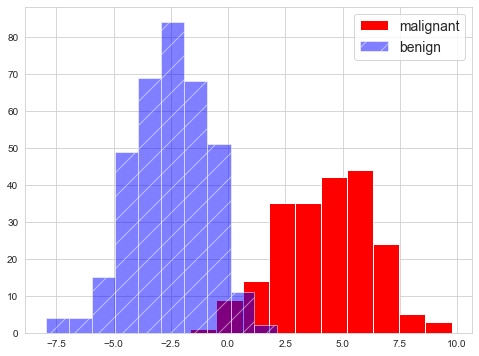

In [10]:
plt.figure(figsize=(8,6))

plt.hist(projected_values[y==1], color='red', alpha=1, label='malignant')
plt.hist(projected_values[y==0], color='blue', hatch='/', alpha=.5, label='benign')

plt.legend(fontsize=14)

plt.show()

`sklearn`'s `LinearDiscriminantAnalysis` model object in addition to being a classification algorithm can also perform this supervised dimensionality reduction. To get the projected values call `LDA.transform(X)` after you fit the LDA model (this assumes that you called the model `LDA` and that your features are stored in `X_scale`.

##### Use `sklearn`'s `LinearDiscriminantAnalysis` instead to perform LDA

Note your results may look slightly different because `sklearn` does not implement the exact same Fisher discriminant calculation as you did above.

In [11]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
LDA = LinearDiscriminantAnalysis()
LDA.fit(X_scale, y)

sklearn_projection = LDA.transform(X_scale)

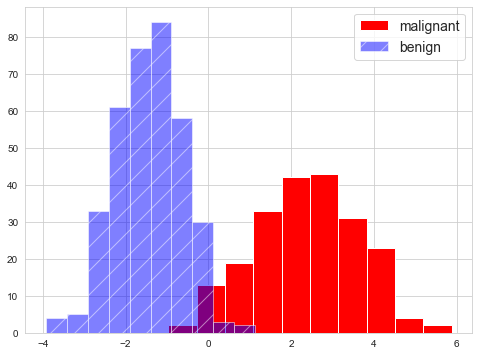

In [12]:
plt.figure(figsize=(8,6))

plt.hist(sklearn_projection[y==1], color='red', alpha=1, label='malignant')
plt.hist(sklearn_projection[y==0], color='blue', hatch='/', alpha=.5, label='benign')

plt.legend(fontsize=14)

plt.show()

While Fisher formulated this approach with binary data in mind, the technique was extended to multiclass data by C.  R. Rao, <a href="https://www.jstor.org/stable/2983775">https://www.jstor.org/stable/2983775</a>. If your data has $C$ possible classes, the multiclass approach will project the data down to a space of dimension at most $C-1$. This too can be implemented by `sklearn`, where you can control the number of components using `n_components` as an argument when you make the `LinearDiscriminantAnalysis` model object.

##### 2. Multi-class LDA dimension reduction

Load the iris data set and perform LDA dimension reduction. Plot the projected points, coloring by iris type.

In [13]:
from sklearn.datasets import load_iris

In [14]:
iris = load_iris()

X = iris['data']
y = iris['target']

In [15]:
LDA = LinearDiscriminantAnalysis()
LDA.fit(X, y)

fit = LDA.transform(X)

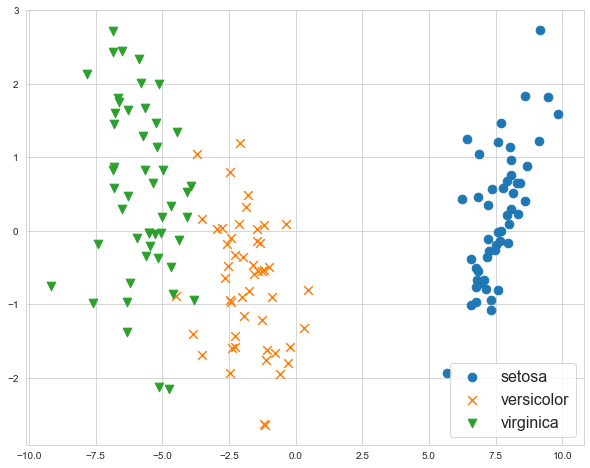

In [16]:
plt.figure(figsize=(10,8))

plt.scatter(fit[y==0,0], fit[y==0,1], s=75, label='setosa')
plt.scatter(fit[y==1,0], fit[y==1,1], marker = 'x', s=75, label='versicolor')
plt.scatter(fit[y==2,0], fit[y==2,1], marker = 'v', s=75, label='virginica')

plt.legend(fontsize=16)

plt.show()

##### 3. Return to cancer data

Return to the cancer data set from 1. This time make a train test split, then make a pipeline that scales the data and ends in LDA.

Instead of using the LDA predictions, we will loop through possible Fisher discriminant cutoff values for classification. That is perform 5-fold cross-validation to check which value of $c$ provides the best TPR, FPR and precision where $c$ is such that $\text{Fisher discriminant } < c$ is classified as benign ($y = 0$) and a discriminat greater than or equal to $c$ is classified as malignant ($y=1$).

Plot the avg. cv. TPR, FPR and precision as a function of $c$.

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import precision_score, confusion_matrix

In [18]:
X = cancer['data']
y = cancer['target']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                       shuffle=True,
                                                       random_state=4031,
                                                       stratify=y)

In [19]:
cs = np.linspace(-5,6,100)

cv_tprs = np.zeros((5, len(cs)))
cv_fprs = np.zeros((5, len(cs)))
cv_precs = np.zeros((5, len(cs)))

kfold = StratifiedKFold(5, shuffle=True, random_state=321)

i = 0
for train_index, test_index in kfold.split(X_train, y_train):
    X_tt = X_train[train_index, :]
    X_ho = X_train[test_index, :]
    y_tt = y_train[train_index]
    y_ho = y_train[test_index]
    
    pipe = Pipeline([('scale', StandardScaler()),
                        ('lda', LinearDiscriminantAnalysis())])
    
    pipe.fit(X_tt, y_tt)
    
    fishers = pipe.transform(X_ho)
    
    j = 0
    for c in cs:
        preds = 1*(fishers >= c)
        
        conf_mat = confusion_matrix(y_ho, preds)
        
        cv_precs[i,j] = precision_score(y_ho, preds)
        
        cv_tprs[i,j] = conf_mat[1,1]/(conf_mat[1,0] + conf_mat[1,1])
        cv_fprs[i,j] = conf_mat[0,1]/(conf_mat[0,0] + conf_mat[0,1])
        
        j = j + 1
    i = i + 1

/Users/matthewosborne/miniforge3/envs/home_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matthewosborne/miniforge3/envs/home_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matthewosborne/miniforge3/envs/home_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matthewosborne/

/Users/matthewosborne/miniforge3/envs/home_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matthewosborne/miniforge3/envs/home_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/matthewosborne/miniforge3/envs/home_env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


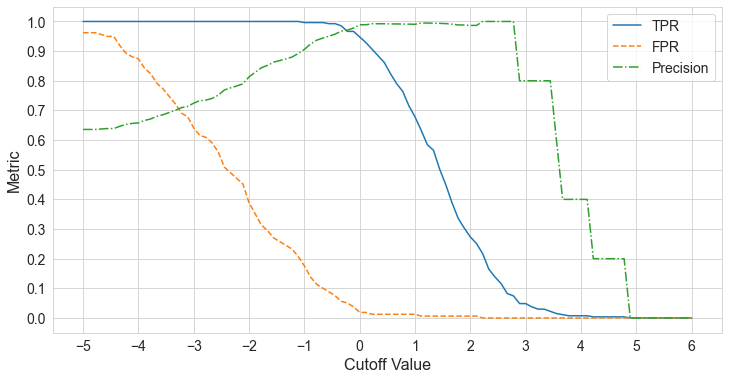

In [20]:
plt.figure(figsize=(12,6))

plt.plot(cs, np.mean(cv_tprs, axis=0), label='TPR')
plt.plot(cs, np.mean(cv_fprs, axis=0), '--', label='FPR')
plt.plot(cs, np.mean(cv_precs, axis=0), '-.', label='Precision')

plt.xlabel("Cutoff Value", fontsize=16)
plt.ylabel("Metric", fontsize=16)

plt.legend(fontsize=14)
plt.yticks(np.arange(0,1.1,.1), fontsize=14)
plt.xticks(np.arange(-5, 7, 1), fontsize=14)
plt.yticks(fontsize=14)

plt.show()

A cutoff of $0$ gives a decent classifier.

##### 4. Spam Classification

One of the initial uses for the na&#xEF;ve Bayes classifier was as an email spam detection algorithm. In this problem you will build such a model.

The data contained in `SMSSpamCollection.tsv` contains $5{,}572$ SMS messages that have been classified as either a spam message or a ham message (aka not spam).

Read in the file, `SMSSpamCollection.tsv` from the `Data` file, then make a `target` column that is `0` if the observation has an `outcome` column value of `"ham"` and a `1` if it is `"spam"`. Finally make a train test split stratified on the `target` column.

<i>Note: Some of the messages may include inappropriate language</i>.

In [21]:
spam = pd.read_table("../../../Data/SMSSpamCollection.tsv")

spam['target'] = 0
spam.loc[spam.outcome=='spam','target'] = 1

In [22]:
spam_train, spam_test = train_test_split(spam.copy(),
                                            shuffle=True,
                                            random_state=4314,
                                            test_size=.2,
                                            stratify=spam['target'])

Using the training set, what is the split between spam and ham messages? Again using the training set to estimate, what would we expect a model that classifies everything as `"ham"` to have as its accuracy, true positive rate and false positive rate?

In [23]:
spam_train.outcome.value_counts(normalize=True)

ham     0.865829
spam    0.134171
Name: outcome, dtype: float64

We would expect such a baseline model to have $86.6\%$ accuracy and true and false positive rates of $0$, assuming we treat spam as the positive class.

The data we will use to build our model are $50$ indicator variables that tell you whether or not a message contains a particular word. For example the column `good` would be `1` if the message contains the word "good" and `0` otherwise.

Use `BernoulliNB` from `sklearn.naive_bayes`, <a href="https://scikit-learn.org/stable/modules/classes.html#module-sklearn.naive_bayes">https://scikit-learn.org/stable/modules/classes.html#module-sklearn.naive_bayes</a> to build the na&#xEF;ve Bayes classifier on these data. Find the average cross-validation accuracy, TPR and FPR.

In [24]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import accuracy_score

In [25]:
text_columns = spam_train.columns[2:-1]

cv_accs = np.zeros(5)
cv_tprs = np.zeros(5)
cv_fprs = np.zeros(5)


kfold = StratifiedKFold(5,shuffle=True,random_state=431)



i = 0
for train_index, test_index in kfold.split(spam_train[text_columns], spam_train['target']):
    spam_train_train = spam_train.iloc[train_index]
    spam_holdout = spam_train.iloc[test_index]
    nb = BernoulliNB()
    
    nb.fit(spam_train_train[text_columns], spam_train_train['target'])
    preds = nb.predict(spam_holdout[text_columns])
    
    cv_accs[i] = accuracy_score(spam_holdout['target'], preds)
    
    conf_mat = confusion_matrix(spam_holdout['target'], preds)
    
    cv_tprs[i] = conf_mat[1,1]/(conf_mat[1,0] + conf_mat[1,1])
    cv_fprs[i] = conf_mat[0,1]/(conf_mat[0,0] + conf_mat[0,1])


    
    i = i + 1

In [26]:
print("AVG CV Accuracy: ", np.mean(cv_accs))
print("AVG CV TPR: ", np.mean(cv_tprs))
print("AVG CV FPR: ", np.mean(cv_fprs))

AVG CV Accuracy:  0.9575961407799973
AVG CV TPR:  0.7827731092436975
AVG CV FPR:  0.01528967829949665


--------------------------

This notebook was written for the Erd&#337;s Institute C&#337;de Data Science Boot Camp by Matthew Osborne, Ph. D., 2023.

Any potential redistributors must seek and receive permission from Matthew Tyler Osborne, Ph.D. prior to redistribution. Redistribution of the material contained in this repository is conditional on acknowledgement of Matthew Tyler Osborne, Ph.D.'s original authorship and sponsorship of the Erdős Institute as subject to the license (see License.md)